In [ ]:
import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error

from gbnet.models.forecasting import Forecast


urls = [
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_multivariate.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_retail_sales.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers2.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_yosemite_temps.csv",
]

datasets = pd.DataFrame([
    {
        'name': url.split('/')[-1],
        'data': pd.read_csv(url),
        'url': url,
        'ycol': (
            'y' if not (url.split('/')[-1] == 'example_pedestrians_multivariate.csv')
            else 'location_4'
        )
    }
    for url in urls
])

n_trials = 500
results = []
for _ in range(n_trials):

    seed = 1110011 + _
    dataset = datasets.sample(1, random_state=seed)

    df = dataset['data'].iloc[0].copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = df[dataset['ycol']].copy()

    np.random.seed(seed)
    train_q = np.random.random()
    test_q = np.random.random()
    train_cutoff = df['ds'].quantile(train_q)
    test_cutoff = df[df['ds'] > train_cutoff]['ds'].quantile(test_q)

    train = df[(df['ds'] <= train_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
    test = df[(df['ds'] > train_cutoff) & (df['ds'] <= test_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()

    #####        
    m = Forecast()
    m.fit(train, train['y'])
    test['gblinear_pred'] = m.predict(test)['yhat']

    #####
    try:
        m = Forecast(
            module_type='LGBModule', params={
                'min_sum_hessian_in_leaf':0,
                'min_data_in_leaf':0
            },
            nrounds=50,
            linear_params={'min_hess': 0.001, 'lambd': 0.001, 'lr': 0.9}
        )
        m.fit(train, train['y'])
        test['gblinear_lightgbm_pred'] = m.predict(test)['yhat']
    except lgb.basic.LightGBMError:
        test['gblinear_lightgbm_pred'] = 0
    

    #####
    pm = Prophet()
    pm.fit(train)
    test['prophet_pred'] = pm.predict(test)['yhat']

    sel = test['y'].notnull()
    results.append({
        'name': dataset['name'].iloc[0],
        'train_q': train_q,
        'test_q': test_q,
        'rmse_gblinear_xgb': root_mean_squared_error(test[sel]['y'], test[sel]['gblinear_pred']),
        'rmse_gblinear_lgb': root_mean_squared_error(test[sel]['y'], test[sel]['gblinear_lightgbm_pred']),
        'rmse_prophet': root_mean_squared_error(test[sel]['y'], test[sel]['prophet_pred'])
    })
    print(results[-1])
        


In [2]:
rrr = pd.DataFrame(results)

In [3]:
rrr = pd.DataFrame(results).rename(columns={
    'rmse_gbnet': 'rmse_ptlinear_xgb',
    'rmse_gbnet_lightgbm': 'rmse_ptlinear_lgb',
    'rmse_gblinear': 'rmse_gblinear_xgb',
    'rmse_gblinear_lightgbm': 'rmse_gblinear_lgb'
})

In [4]:
mp = {
    0: 'gblinear_xgb',
    1: 'gblinear_lgb',
    2: 'prophet'
}

cols = ['rmse_gblinear_xgb', 'rmse_gblinear_lgb', 'rmse_prophet']

pd.Series(np.argmin(rrr[cols], 1)).map(mp).value_counts()

gblinear_lgb    248
gblinear_xgb    160
prophet          92
Name: count, dtype: int64

In [5]:
import numpy as np
def calculate_pairwise_win_rates(df, mae_columns):
    """
    Calculate pairwise win rates between MAE columns where lower values are better.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing MAE columns
    mae_columns (list): List of column names containing MAE values
    
    Returns:
    pandas.DataFrame: Matrix of win rates where entry [i,j] represents how often model i beats model j
    """
    n_models = len(mae_columns)
    win_rates = np.zeros((n_models, n_models))
    
    for i, model1 in enumerate(mae_columns):
        for j, model2 in enumerate(mae_columns):
            if i != j:
                # Count how often model1 has lower MAE than model2
                wins = (df[model1] < df[model2]).sum()
                total_comparisons = len(df)
                win_rates[i,j] = wins / total_comparisons
    
    # Create DataFrame with nice labels
    result = pd.DataFrame(
        win_rates,
        columns=[col.replace('test_mae_', '') for col in mae_columns],
        index=[col.replace('test_mae_', '') for col in mae_columns]
    )
    
    return result

In [6]:
calculate_pairwise_win_rates(rrr, cols)

,rmse_gblinear_xgb,rmse_gblinear_lgb,rmse_prophet
rmse_gblinear_xgb,0.000,0.428,0.794
rmse_gblinear_lgb,0.572,0.000,0.788
rmse_prophet,0.206,0.212,0.000


In [7]:
rrr['gblinear_lgb_win_rate'] = rrr['rmse_gblinear_lgb'] < rrr['rmse_prophet']
rrr.groupby('name')['gblinear_lgb_win_rate'].mean()

name
example_air_passengers.csv              0.740000
example_pedestrians_covid.csv           0.785714
example_pedestrians_multivariate.csv    0.666667
example_retail_sales.csv                0.853333
example_wp_log_R.csv                    0.898305
example_wp_log_R_outliers1.csv          0.833333
example_wp_log_R_outliers2.csv          0.775510
example_wp_log_peyton_manning.csv       0.622222
example_yosemite_temps.csv              0.846154
Name: gblinear_lgb_win_rate, dtype: float64

In [8]:
rrr['gblinear_xgb_win_rate'] = rrr['rmse_gblinear_xgb'] < rrr['rmse_prophet']
rrr.groupby('name')['gblinear_xgb_win_rate'].mean()

name
example_air_passengers.csv              0.780000
example_pedestrians_covid.csv           0.767857
example_pedestrians_multivariate.csv    0.703704
example_retail_sales.csv                0.853333
example_wp_log_R.csv                    0.915254
example_wp_log_R_outliers1.csv          0.816667
example_wp_log_R_outliers2.csv          0.775510
example_wp_log_peyton_manning.csv       0.622222
example_yosemite_temps.csv              0.846154
Name: gblinear_xgb_win_rate, dtype: float64

Text(0.5, 1.0, 'When method loses how bad does it lose?')

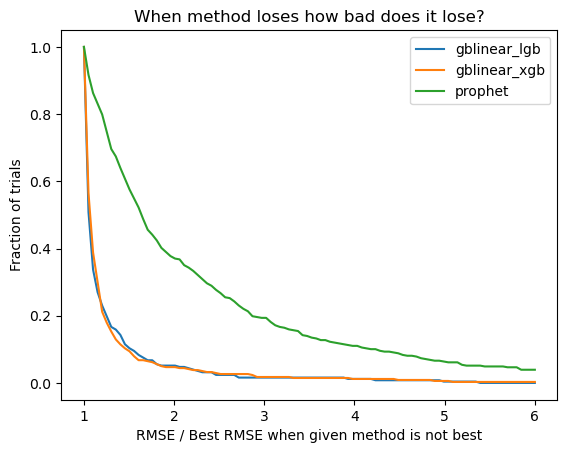

In [9]:
pd.options.display.max_rows=1000

rrr['min'] = rrr[cols].min(1)

def get_ratios(col):
    col_ratio = rrr[col] / rrr['min']

    xgrid = np.linspace(1,6, 100)
    
    res = []
    for x in xgrid:
        res.append({
            'x': x,
            'p': (col_ratio[rrr[col] > rrr['min']] > x).mean()
        })
    res = pd.DataFrame(res)
    return res



res = get_ratios('rmse_gblinear_lgb')
plt.plot(res['x'], res['p'], label='gblinear_lgb')

res = get_ratios('rmse_gblinear_xgb')
plt.plot(res['x'], res['p'], label='gblinear_xgb')

res = get_ratios('rmse_prophet')
plt.plot(res['x'], res['p'], label='prophet')

#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel('RMSE / Best RMSE when given method is not best')
plt.ylabel('Fraction of trials')
plt.title('When method loses how bad does it lose?')